# Geometric Positioning of InSAR Points

@author: Max Felius

## Hypothesis
The retrieval of sinkhole parameters can be improved by a better spreading of the measurement points.
- A better spreading of points will lead to a lower conditional number of the design matrix.
- A better spreading will lead to a higher fitting percentage and a lower RMSE.

## Predictions (better articulate this part...)
- Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Less points will provide a worse fit.
- Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- The further the points away from the center, the worse the fit will be.
- Very heterogenous points will provide a worse fit
- The more points with the same radius will give worse fit

## Design the experiment
- Define sinkhole using kinematic model
- Define inverse model to retrieve parameters
- Define tool to create point samples
- Generate seperate cases for each prediction and answer that prediction

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import random
import os,sys,time

In [2]:
#kinematic model
def zg(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))

In [3]:
#defining the inverse model
def inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
            print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
    if i == n-1:
        print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
    print(f'The total runtime was: {time.time()-start} seconds.')
    
    return v, R, i

In [10]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 95.78920335026163
R_wink2016_gaus = 553.0609564207195
t = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 25
y0 = 25

#Define the sinkhole grid
n = 100
x_range = R_wink2016_gaus
y_range = R_wink2016_gaus
x = np.linspace(x0-x_range/2,x0+x_range/2,n)
y = np.linspace(y0-y_range/2,y0+y_range/2,n)

#creat x/y grid
xv, yv = np.meshgrid(x,y)

#unravel the grids
x_unravel = xv.ravel()
y_unravel = yv.ravel()

In [25]:
'''
Example of how to create subsamples
'''
#example 1
n_sub = 30
idx = random.sample(range(0,len(x_unravel)),int(n_sub))

In [26]:
'''
Defining the points to be evalutad
'''
#subsampling the arrays
x_sub = x_unravel[idx]
y_sub = y_unravel[idx]

#compute the radius
r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

#create row arrays for x,y,z containing every epoch
x_array = np.array([])
y_array = np.array([])
z_array = np.array([])

for step in t:
        x_array = np.concatenate((x_array,x_sub))
        y_array = np.concatenate((y_array,y_sub))
        z_array = np.concatenate((z_array,step*v_wink2016_gaus*zg(R_wink2016_gaus,r)))

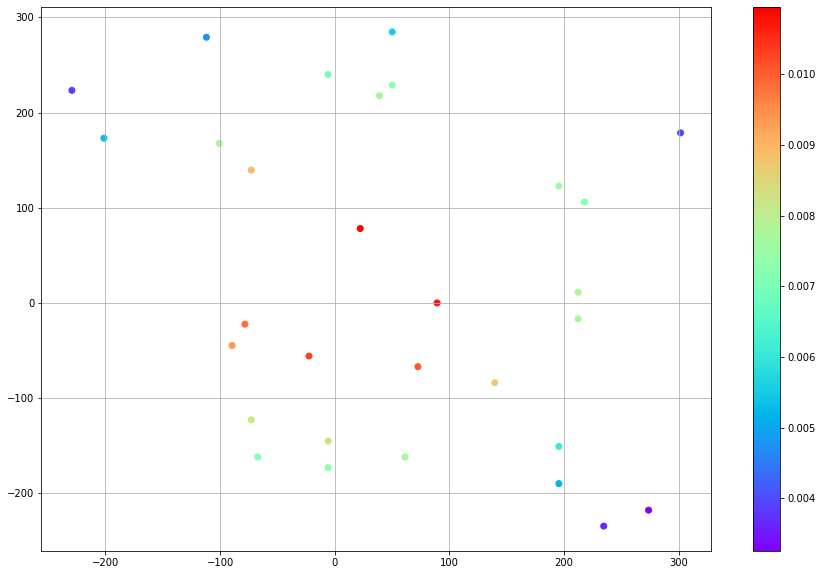

In [27]:
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(15,10))
i = 3
h = axs.scatter(x_sub,y_sub,c=z_array[i*n_sub:n_sub+i*n_sub],cmap=plt.cm.rainbow)
plt.grid(True)
fig.colorbar(h);

In [7]:
#variables
#coordinates of center point to be evaluated
x0 = 25
y0 = 25

#initial parameters
R = 500
v = 100




sub_sample = [10,20,30,40,50,60,100,200,300,400,500,600,1000,2000,5000,9000]
# sub_sample = [x for x in range(1,10)] + [x for x in range(10,100,10)]# + [x for x in range(100,1000,100)]
runs = 1

ydata = np.zeros((runs,len(sub_sample)))
xdata = np.zeros((runs,len(sub_sample)))
ndata = np.zeros((runs,len(sub_sample)))

for line in range(runs):
    #Subsample the number of points
    for num,factor in enumerate(sub_sample):
        n_sub = factor
        idx = random.sample(range(0,len(z_eval)),int(n_sub))

        #subsampled points
        z2 = z_eval[idx]
        x2 = xv.ravel()[idx]
        y2 = yv.ravel()[idx]
        r = np.sqrt((x2-x0)**2 + (y2-y0)**2)

        #building the design matrix
        #defining the jacobian matrix
        A1 = t[i]*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t[i])*zg(R,r)

        J = np.array([A1,A2]).T

#         print(factor,line,idx,len(r),xdata.shape)
        
        v, R, n = inverse_kinematic_model(v,t[i],R,r,z2)
    
        xdata[line,num] = len(r)
        ydata[line,num] = np.linalg.cond(J)
        ndata[line,num] = n


Stopped at iteration 9.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.006227970123291016 seconds.
Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.0008499622344970703 seconds.
Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.0007600784301757812 seconds.
Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.0069561004638671875 seconds.
Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.009654045104980469 seconds.
Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.0006656646728515625 seconds.
Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.00

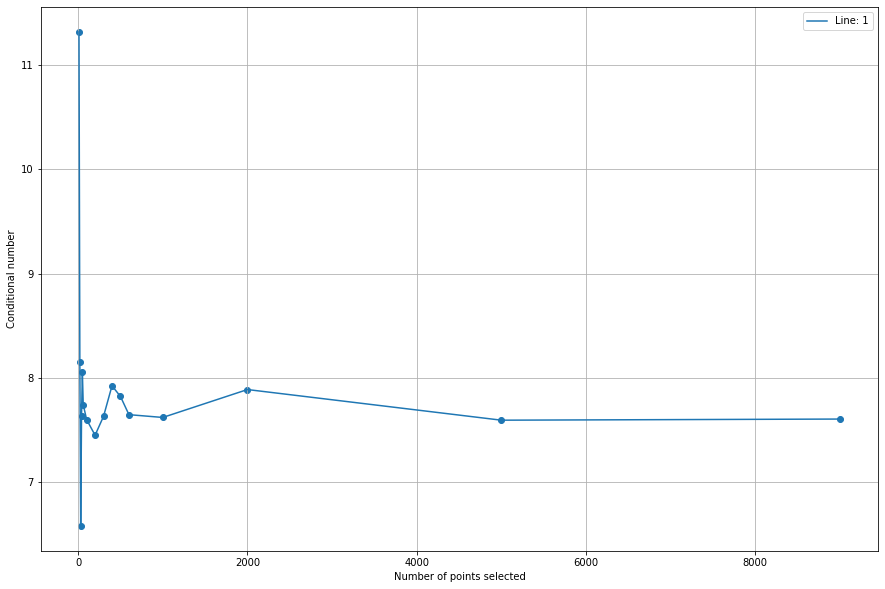

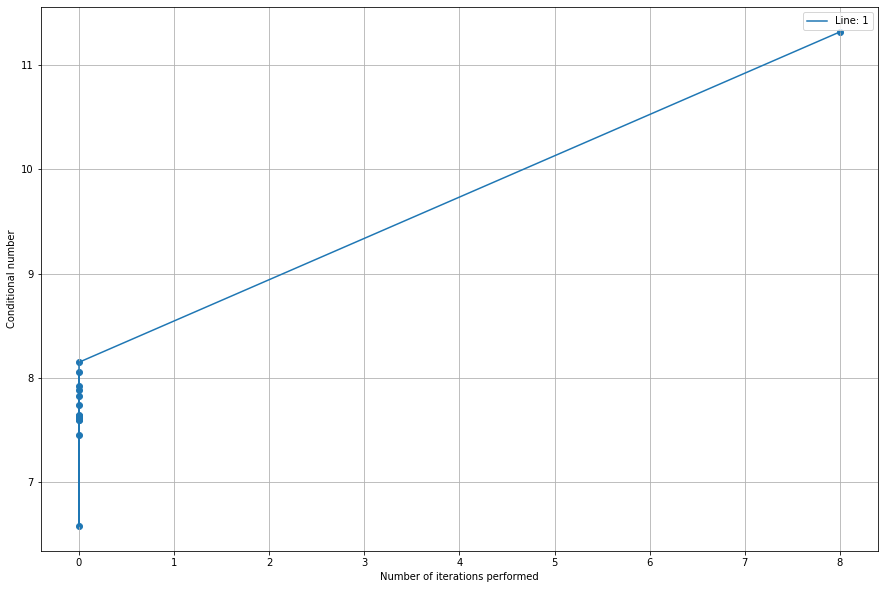

In [8]:
plt.figure(figsize=(15,10))

for line in range(runs):
    plt.plot(xdata[line,:],ydata[line,:],label=f'Line: {line+1}')
    plt.scatter(xdata[line,:],ydata[line,:])
plt.xlabel('Number of points selected')
plt.ylabel('Conditional number')
plt.legend()
plt.grid(True);

plt.figure(figsize=(15,10))

for line in range(runs):
    plt.plot(ndata[line,:],ydata[line,:],label=f'Line: {line+1}')
    plt.scatter(ndata[line,:],ydata[line,:])
plt.xlabel('Number of iterations performed')
plt.ylabel('Conditional number')
plt.legend()
plt.grid(True);

Stopped at iteration 1.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.0006520748138427734 seconds.


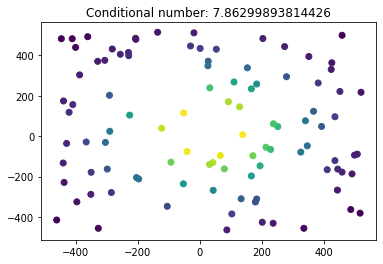

In [9]:
idx = random.sample(range(0,len(z_eval)),int(100))

#subsampled points
z2 = z_eval[idx]
x2 = xv.ravel()[idx]
y2 = yv.ravel()[idx]
r = np.sqrt((x2-x0)**2 + (y2-y0)**2)

#building the design matrix
#defining the jacobian matrix
A1 = t[i]*zg(R,r)
A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t[i])*zg(R,r)

J = np.array([A1,A2]).T

v, R, n = inverse_kinematic_model(v,t[i],R,r,z2)


plt.figure()
plt.scatter(x2,y2,c=z2)
plt.title(f'Conditional number: {np.linalg.cond(J)}');
